# Support Vector Machine Model for Diabetes Prediction

In [1]:
import pandas as pd
import numpy as np
import pickle
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score, precision_score

## 1. Data Acquisition

In [2]:
# Reading the dataset
df = pd.read_csv("../datasets/Processed_data.csv", sep=",", index_col="PatientID")
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (15298, 18)


,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic,BMI_Age_Ratio,ISI,BP_Age_Ratio,HighRiskPregnancy,Glucose_Insulin,Pregnancies_Age_Ratio,Metabolic_Risk,Pedigree_Glucose,Fat_Index
PatientID,,,,,,,,,,,,,,,,,,
1,0,158,80,34,23,43.509726,0.981927,21,0,2.071892,2.751789,3.809524,0.000000,3634,0.000000,93.836575,155.144416,38.754863
2,7,103,78,25,269,29.582192,0.981927,43,1,0.687958,0.360920,1.813953,4.815706,27707,0.162791,70.194064,101.138448,27.291096
3,1,85,59,27,35,42.604536,0.549542,22,0,1.936570,3.361345,2.681818,1.936570,2975,0.045455,62.201512,46.711059,34.802268
4,0,82,92,9,253,19.724160,0.103424,26,0,0.758622,0.482021,3.538462,0.000000,20746,0.000000,64.574720,8.480809,14.362080
5,0,133,49,19,227,21.941357,0.174160,21,0,1.044827,0.331225,2.333333,0.000000,30191,0.000000,67.980452,23.163251,20.470678


## 2. Data Preparation

In [3]:
# Split data into training and testing sets
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

print(f"Training data shape: {df_train.shape}")
print(f"Testing data shape: {df_test.shape}")

Training data shape: (12238, 18)
Testing data shape: (3060, 18)


In [4]:
# Define feature columns
feature_columns = ['Pregnancies', 'PlasmaGlucose', 'DiastolicBloodPressure',
                   'TricepsThickness', 'SerumInsulin', 'BMI', 'DiabetesPedigree', 'Age']

# Extract features and target for training data
X_train = df_train.loc[:, feature_columns].values
y_train = df_train.Diabetic.values

# Extract features and target for test data
X_test = df_test.loc[:, feature_columns].values
y_test = df_test.Diabetic.values

## 3. SVM Model Implementation

In [5]:
# Initialize and train the base SVM model
print("Training base SVM model...")
start_time = time.time()

svm_model = SVC(C=1.0, kernel="rbf", gamma="scale", random_state=42)
svm_model.fit(X_train, y_train)

end_time = time.time()
training_time = end_time - start_time
print(f"SVM training completed in {training_time:.2f} seconds")

Training base SVM model...
SVM training completed in 1.69 seconds


In [6]:
# Make predictions with the base model
y_pred = svm_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Base SVM Model Accuracy: {accuracy:.4f}")

Base SVM Model Accuracy: 0.8356


## 4. Model Evaluation

### 4.1 Confusion Matrix

In [7]:
# Create confusion matrix
cf = pd.DataFrame(
    columns=["y_test_0", "y_test_1"], 
    index=["y_pred_0", "y_pred_1"]
)

cf.loc[:, :] = confusion_matrix(y_true=y_test, y_pred=y_pred)
cf

,y_test_0,y_test_1
y_pred_0,1298,259
y_pred_1,244,1259


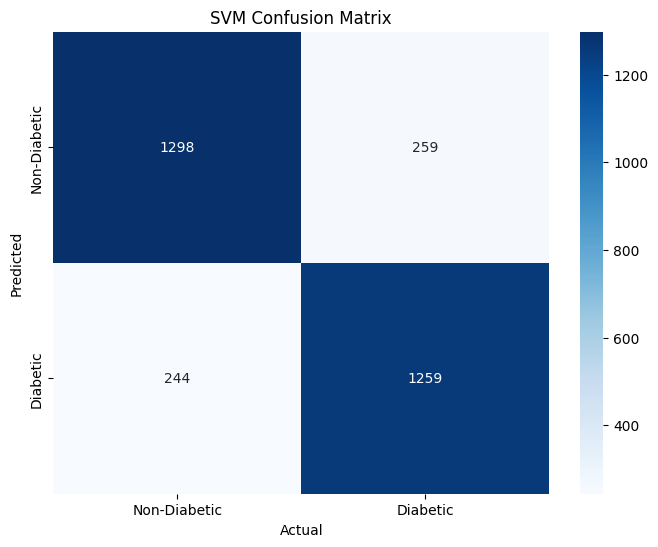

In [20]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Diabetic', 'Diabetic'],
            yticklabels=['Non-Diabetic', 'Diabetic'])
plt.title('SVM Confusion Matrix')
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.show()

### 4.2 Classification Metrics

In [9]:
# Calculate recall and precision
recall = recall_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred)

print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")

Recall: 0.8377
Precision: 0.8294


In [10]:
# Generate full classification report
report = classification_report(y_true=y_test, y_pred=y_pred)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.83      0.84      1557
           1       0.83      0.84      0.83      1503

    accuracy                           0.84      3060
   macro avg       0.84      0.84      0.84      3060
weighted avg       0.84      0.84      0.84      3060



## 5. Hyperparameter Tuning

In [11]:
print("Starting hyperparameter tuning with GridSearchCV...")
print("Note: This process can take a long time (potentially hours) to complete.")

# Define parameter grid (reduced to speed up execution)
param_grid = {
    'C': [0.1, 1, 10],  # Reduced from [0.1, 1, 10, 100]
    'gamma': ['scale', 'auto', 0.1],  # Fixed typo and reduced options
    'kernel': ['rbf', 'linear']
}

# Setup grid search with parallelization
start_time = time.time()

grid_search = GridSearchCV(
    SVC(random_state=42),
    param_grid, 
    cv=5,
    n_jobs=-1,  # Use all available cores
    verbose=1   # Show progress
)

grid_search.fit(X_train, y_train)

end_time = time.time()
tuning_time = end_time - start_time

print(f"\nGrid search completed in {tuning_time:.2f} seconds ({tuning_time/60:.2f} minutes)")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Score: {grid_search.best_score_:.4f}")

Starting hyperparameter tuning with GridSearchCV...
Note: This process can take a long time (potentially hours) to complete.
Fitting 5 folds for each of 18 candidates, totalling 90 fits

Grid search completed in 676.86 seconds (11.28 minutes)
Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best Cross-Validation Score: 0.8715


## 6. Final Model and Evaluation

In [12]:
# Create final model with best parameters
final_model = SVC(
    C=grid_search.best_params_['C'],
    gamma=grid_search.best_params_['gamma'],
    kernel=grid_search.best_params_['kernel'],
    random_state=42
)

# Train final model
final_model.fit(X_train, y_train)

# Predict with optimized model
y_pred_final = final_model.predict(X_test)

# Calculate accuracy
final_accuracy = accuracy_score(y_test, y_pred_final)
print(f"Final Optimized SVM Model Accuracy: {final_accuracy:.4f}")

Final Optimized SVM Model Accuracy: 0.8778


In [13]:
# Generate final classification report
final_report = classification_report(y_test, y_pred_final)
print("Final Classification Report:")
print(final_report)

Final Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.86      0.88      1557
           1       0.86      0.89      0.88      1503

    accuracy                           0.88      3060
   macro avg       0.88      0.88      0.88      3060
weighted avg       0.88      0.88      0.88      3060



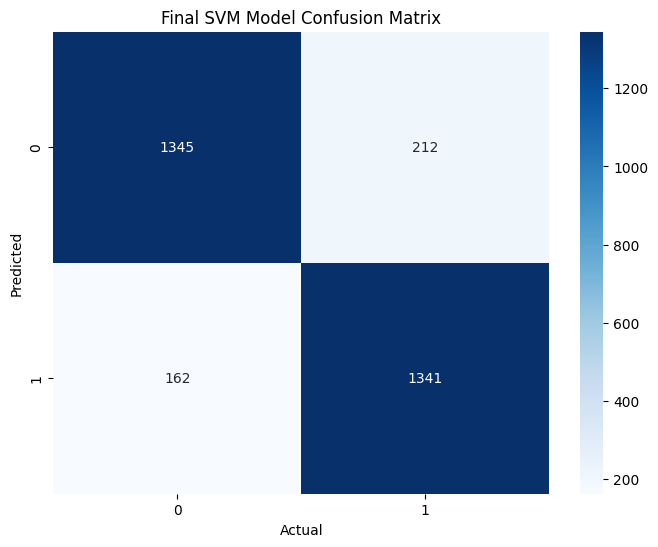

In [14]:
# Create final confusion matrix
final_cf = confusion_matrix(y_test, y_pred_final)

# Visualize final confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(final_cf, annot=True, fmt='d', cmap='Blues')
plt.title('Final SVM Model Confusion Matrix')
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.show()

In [15]:
# Comparison between base and optimized models
print(f"Base SVM Model Accuracy: {accuracy:.4f}")
print(f"Optimized SVM Model Accuracy: {final_accuracy:.4f}")
print(f"Improvement: {(final_accuracy - accuracy) * 100:.2f}%")

Base SVM Model Accuracy: 0.8356
Optimized SVM Model Accuracy: 0.8778
Improvement: 4.22%


In [16]:
# Saving the model
with open('../svm_model.pkl', 'wb') as file:
    pickle.dump(final_model, file)
    
print("Model saved successfully to '../svm_model.pkl'")

Model saved successfully to '../svm_model.pkl'
